<a href="https://colab.research.google.com/github/verg1lio/XangoER/blob/rascunho_Leonardo/Simula%C3%A7%C3%A3o_motor_gaiola.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

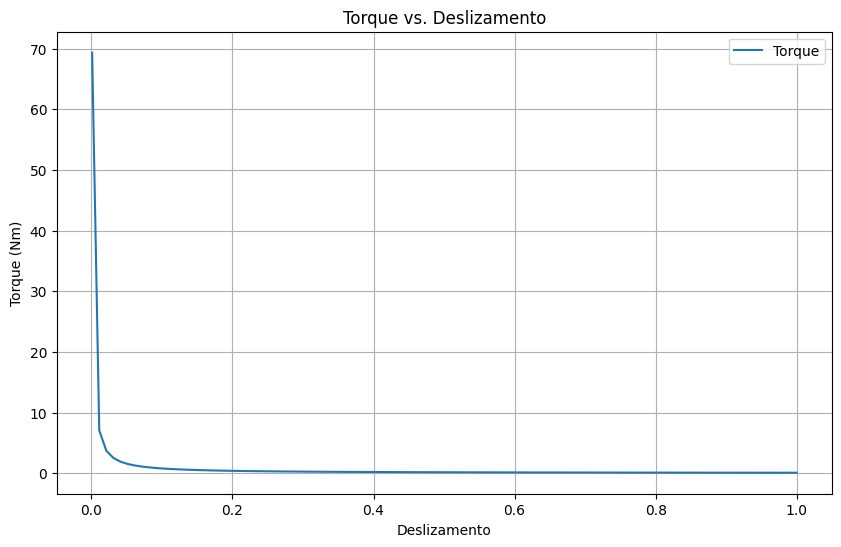

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Parâmetros do motor (exemplo)
V_linha = 400  # Tensão da linha em Volts
frequencia = 60  # Frequência em Hz
P = 2  # Número de polos
R1 = 0.01  # Resistência do estator em ohms
X1 = 1.106  # Reatância do estator em ohms
R2 = 0.01  # Resistência do rotor em ohms
X2 = 0.464  # Reatância do rotor em ohms
Xm = 26.3  # Reatância magnetizante em ohms

# Velocidade síncrona (rad/s)
w_s = 2 * np.pi * frequencia / (P / 2)

# Tensão de fase
V_fase = V_linha / np.sqrt(2)

# Criação de um vetor de deslizamento s variando de 0 (síncrono) a 1 (parado)
s = np.linspace(0.001, 1, 100)

# Cálculo do torque para diferentes valores de deslizamento
T = (3 * (V_fase ** 2) * R2 / s) / (
    w_s * ((R1 + (R2 / s)) ** 2 + (X1 + X2 + Xm) ** 2)
)

# Conversão do torque para Nm
T = T * 9.5488

# Plotando o torque vs. deslizamento
plt.figure(figsize=(10, 6))
plt.plot(s, T, label='Torque')
plt.title('Torque vs. Deslizamento')
plt.xlabel('Deslizamento')
plt.ylabel('Torque (Nm)')
plt.grid(True)
plt.legend()
plt.show()

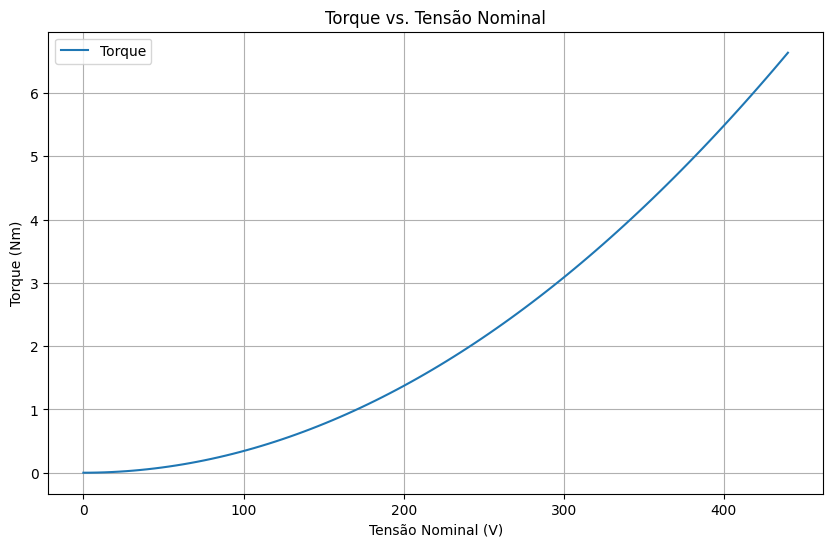

In [2]:
# Deslizamento específico para a análise
s_fixo = 0.0095

# Variação da tensão nominal
V_linha = np.linspace(0, 440, 100)  # Variação da tensão da linha em Volts
V_fase = V_linha / np.sqrt(3)  # Tensão de fase correspondente

# Cálculo do torque para diferentes valores de tensão
T = (3 * (V_fase ** 2) * R2 / s_fixo) / (
    w_s * ((R1 + (R2 / s_fixo)) ** 2 + (X1 + X2 + Xm) ** 2)
)

# Conversão do torque para Nm
T = T * 9.5488

# Plotando o torque vs. tensão nominal
plt.figure(figsize=(10, 6))
plt.plot(V_linha, T, label='Torque')
plt.title('Torque vs. Tensão Nominal')
plt.xlabel('Tensão Nominal (V)')
plt.ylabel('Torque (Nm)')
plt.grid(True)
plt.legend()
plt.show()

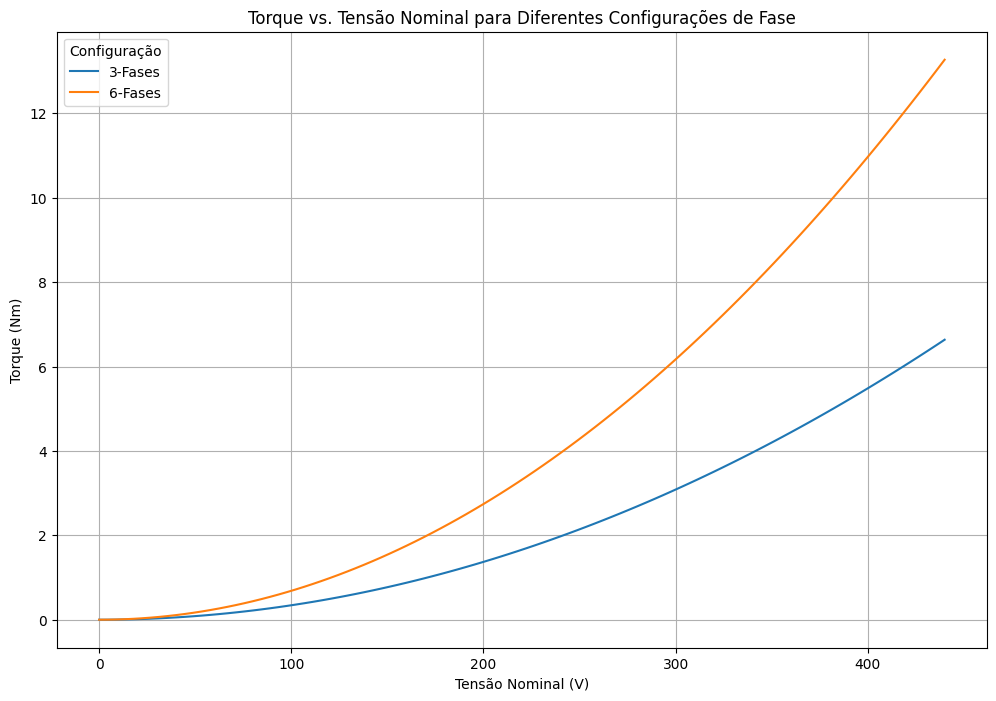

In [3]:
V_linha = np.linspace(0, 440, 100)  # Variação da tensão da linha em Volts

# Variação no número de fases
num_fases = np.array([3, 6])  # Exemplo: monofásico, trifásico, e "hexafásico"
legenda = [ 'Trifásico', 'Hexafásico']

plt.figure(figsize=(12, 8))

for n in num_fases:
    # Ajuste na tensão de fase com base no número de fases
    if n > 1:
        V_fase = V_linha / np.sqrt(3)  # Aproximação para sistemas com mais de uma fase
    else:
        V_fase = V_linha  # Para monofásico

    # Cálculo do torque
    T = (n * (V_fase ** 2) * R2 / s_fixo) / (
        (2 * np.pi * frequencia / (P / 2)) * ((R1 + (R2 / s_fixo)) ** 2 + (X1 + X2 + Xm) ** 2)
    )

    # Conversão do torque para Nm
    T = T * 9.5488

    # Plot
    plt.plot(V_linha, T, label=f'{n}-Fases')

plt.title('Torque vs. Tensão Nominal para Diferentes Configurações de Fase')
plt.xlabel('Tensão Nominal (V)')
plt.ylabel('Torque (Nm)')
plt.grid(True)
plt.legend(title="Configuração")
plt.show()

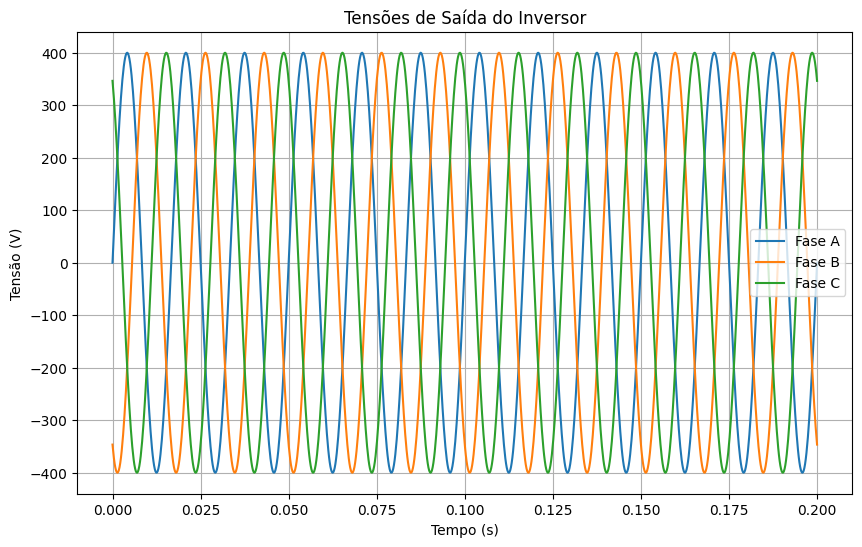

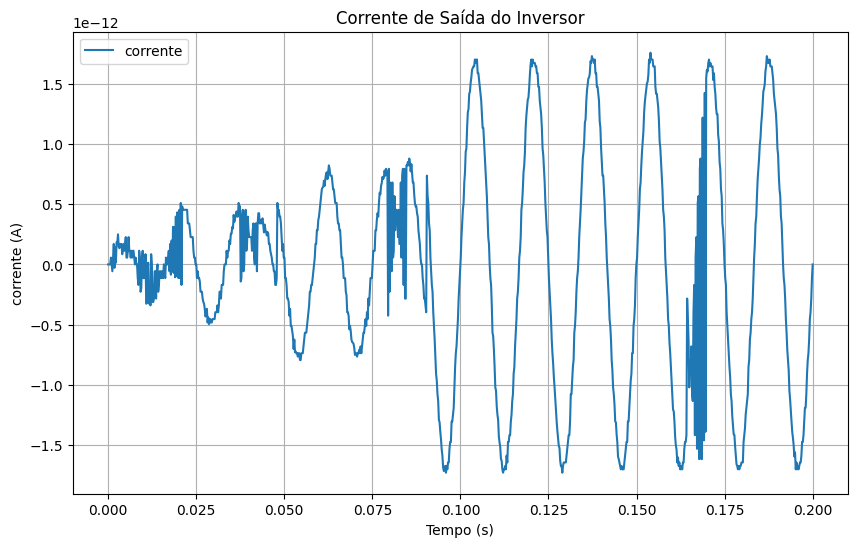

In [11]:
import numpy as np
import matplotlib.pyplot as plt

class InversorWEGCFW300:
    def __init__(self, V_m, f, V_dc, i_dc, phi, theta, f_s, m):
        self.V_m = V_m  # Tensão de entrada RMS (V)
        self.f = f  # Frequência de entrada (Hz)
        self.V_dc = V_dc  # Tensão CC (V)
        self.i_dc = i_dc  # Corrente CC (A)
        self.phi = phi  # Ângulo de fase da tensão de entrada (rad)
        self.theta = theta  # Ângulo de fase da corrente de saída (rad)
        self.f_s = f_s  # Frequência de chaveamento (Hz)
        self.m = m  # Índice de modulação

        # Cálculo do período de chaveamento
        self.T_s = 1 / f_s

        # Cálculo do ângulo de modulação
        self.theta_m = np.arcsin(m)

        # Cálculo da frequência angular de entrada
        self.omega = 2 * np.pi * f

        # Cálculo da tensão de saída fundamental
        self.V_o1 = (2 * V_dc / np.pi) * m

    def gerar_tensoes_saida(self, t):
        u_a = self._gerar_funcao_comutacao(t, self.theta_m)
        u_b = self._gerar_funcao_comutacao(t, self.theta_m + 2 * np.pi / 3)
        u_c = self._gerar_funcao_comutacao(t, self.theta_m + 4 * np.pi / 3)

        v_sw_a = self.V_dc * u_a
        v_sw_b = self.V_dc * u_b
        v_sw_c = self.V_dc * u_c

        v_a = v_sw_a * np.sin(self.omega * t - self.phi)
        v_b = v_sw_b * np.sin(self.omega * t - self.phi - 2 * np.pi / 3)
        v_c = v_sw_c * np.sin(self.omega * t - self.phi + 2 * np.pi / 3)

        return v_a, v_b, v_c

    def _gerar_funcao_comutacao(self, t, theta_m):
    # Cálculo do índice de chaveamento para cada ponto de tempo t
      k = np.floor((t + self.T_s / 4) / self.T_s)

    # Cálculo da função de comutação para cada ponto de tempo t
      u = (t < (k * self.T_s + theta_m)).astype(int)

      return u


# Parâmetros do inversor
V_m = 220  # Tensão de entrada RMS (V)
f = 60  # Frequência de entrada (Hz)
V_dc = 400  # Tensão CC (V)
i_dc = 2  # Corrente CC (A)
phi = 0  # Ângulo de fase da tensão de entrada (rad)
theta = 0  # Ângulo de fase da corrente de saída (rad)
f_s = 10000  # Frequência de chaveamento (Hz)
m = 0.8  # Índice de modulação

# Tempo de simulação
t_sim = 0.2
t = np.linspace(0, t_sim, 1000)  # Cálculo do vetor tempo

# Instância do inversor
inversor = InversorWEGCFW300(V_m, f, V_dc, i_dc, phi, theta, f_s, m)

# Geração das tensões de saída
v_a, v_b, v_c = inversor.gerar_tensoes_saida(t)

Z=1
i2= v_a+ v_b+ v_c
i_ef = (2/3)*((v_a/np.sqrt(2))/Z + (v_b/np.sqrt(2))*(v_a/Z)/Z + (v_c/np.sqrt(2))*(v_a/Z)**2)
i= np.abs(i_ef)
# Plotando as tensões de saída
plt.figure(figsize=(10, 6))

plt.plot(t, v_a, label='Fase A')
plt.plot(t, v_b, label='Fase B')
plt.plot(t, v_c, label='Fase C')
plt.title('Tensões de Saída do Inversor')
plt.xlabel('Tempo (s)')
plt.ylabel('Tensão (V)')
plt.legend()
plt.grid(True)
plt.show()


plt.figure(figsize=(10, 6))
plt.plot(t,i2, label='corrente')
plt.title('Corrente de Saída do Inversor')
plt.xlabel('Tempo (s)')
plt.ylabel('corrente (A)')
plt.legend()
plt.grid(True)
plt.show()



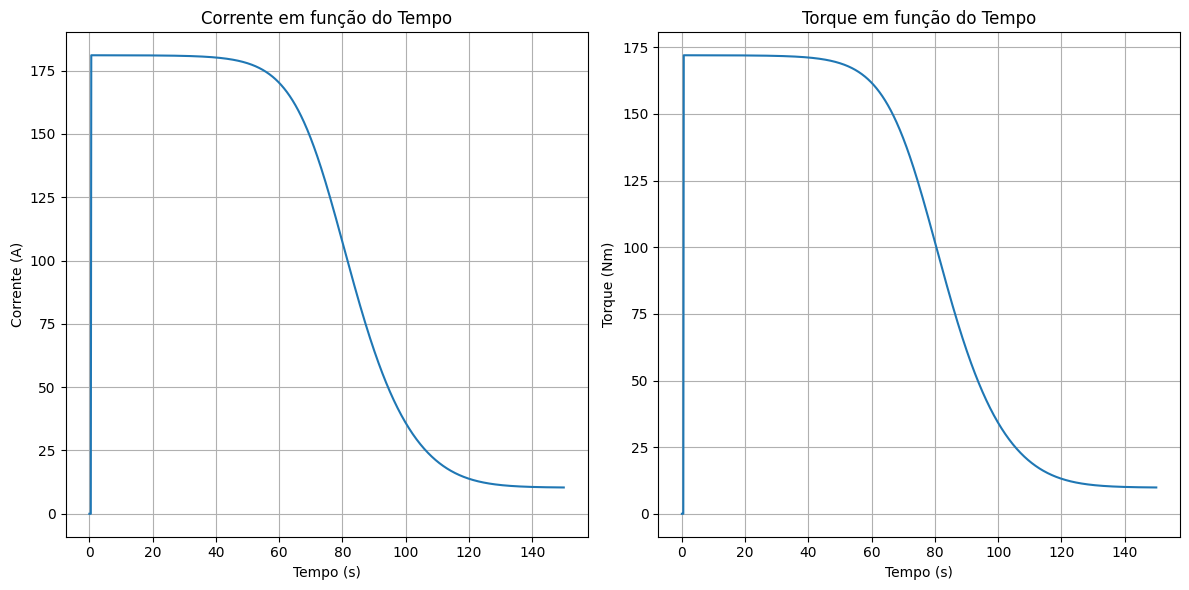

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import cmath  # Para operações com números complexos

class MotorDeGaiola:
    def __init__(self, frequencia, P, R1, X1, R2, X2, Xm, K):
        self.frequencia = frequencia
        self.P = P
        self.R1 = R1
        self.X1 = X1
        self.R2 = R2
        self.X2 = X2
        self.Xm = Xm
        self.K = K  # Constante de proporcionalidade para o torque
        self.w_s = 2 * np.pi * self.frequencia / (self.P / 2)  # Velocidade síncrona

    def calcular_impedancia(self, s):
        j = complex(0, 1)
        Z1 = self.R1 + j * self.X1
        Z2 = (self.R2 / s) + j * self.X2
        Zm = j * self.Xm
        Z2_prime = Z2 * Zm / (Z2 + Zm)

        return Z1 + Z2_prime

    def calcular_corrente(self, V_fase, s):
        Z_total = self.calcular_impedancia(s)
        I_1 = V_fase / Z_total
        return abs(I_1)

    def calcular_torque_da_corrente(self, I):
        return self.K * I  # Torque é proporcional à corrente

    def simular_partida_com_degrau_na_tensao(self, t_final, num_steps, V_step_time, V_linha_max):
        t = np.linspace(0, t_final, num_steps)
        V_fase = [V_linha_max / np.sqrt(2) if ti >= V_step_time else 0 for ti in t]
        s = np.exp(-t / t_final * 10)  # Deslizamento decai exponencialmente
        corrente = [self.calcular_corrente(V, si) for V, si in zip(V_fase, s)]
        torque = [self.calcular_torque_da_corrente(i) for i in corrente]

        plt.figure(figsize=(12, 6))
        plt.subplot(1, 2, 1)
        plt.plot(t, corrente, label='Corrente (A)')
        plt.title('Corrente em função do Tempo')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Corrente (A)')
        plt.grid(True)

        plt.subplot(1, 2, 2)
        plt.plot(t, torque, label='Torque (Nm)')
        plt.title('Torque em função do Tempo')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Torque (Nm)')
        plt.grid(True)

        plt.tight_layout()
        plt.show()

# Parâmetros do motor
frequencia = 60
P = 2
R1 = 0.01
X1 = 1.106
R2 = 0.01
X2 = 0.464
Xm = 26.3
K = 0.95  # Constante de proporcionalidade para o torque
V_linha_max = 400  # Tensão máxima de linha após o degrau

# Criar instância do Motor de Gaiola
motor = MotorDeGaiola(frequencia, P, R1, X1, R2, X2, Xm, K)

# Simulação da partida do motor com entrada degrau na tensão
motor.simular_partida_com_degrau_na_tensao(t_final=150, num_steps=1000, V_step_time=0.5, V_linha_max=V_linha_max)


<ipython-input-14-d790ed8404cb>:18: RuntimeWarning: divide by zero encountered in scalar divide
  return np.cos(np.arctan((np.abs(s) * self.L2 - self.L1) / (self.R2 * np.abs(s))))


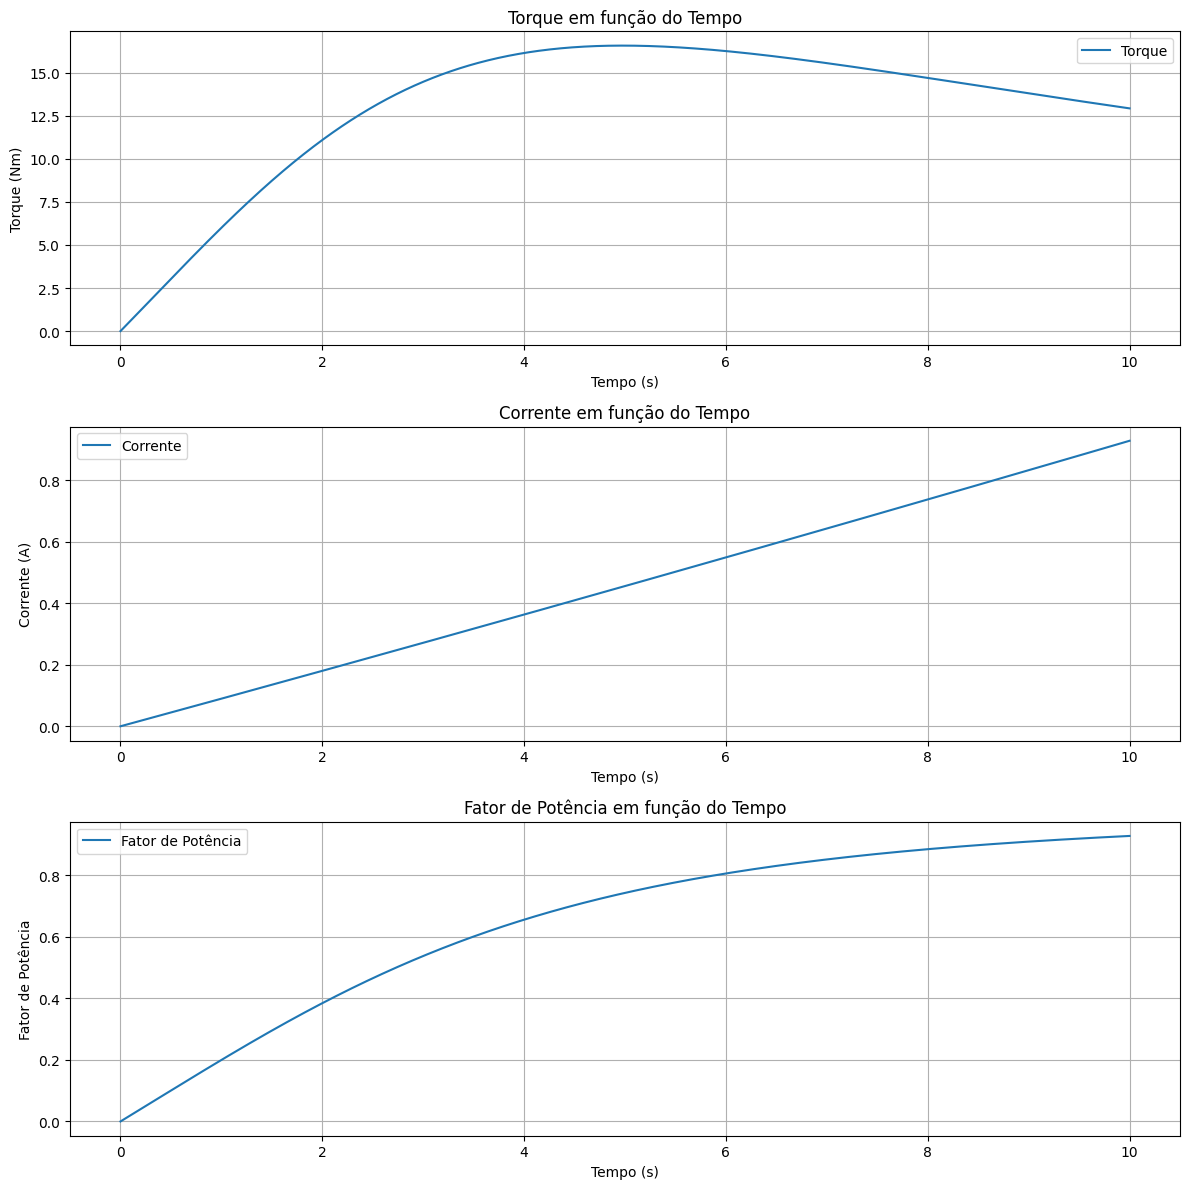

In [14]:
import numpy as np
import matplotlib.pyplot as plt

class MotorDeGaiola:
    def __init__(self, R1, R2, L1, L2):
        self.R1 = R1  # Resistência do rotor
        self.R2 = R2  # Resistência do estator
        self.L1 = L1  # Indutância do rotor
        self.L2 = L2  # Indutância do estator

    def calcular_torque(self, s):
        return (3 * self.R2 * np.abs(s)) / (np.abs(s)**2 * self.R2**2 + (np.abs(s) * self.L2 - self.L1)**2)

    def calcular_corrente(self, s):
        return (self.R2 * np.abs(s)) / np.sqrt(self.R2**2 + (np.abs(s) * self.L2 - self.L1)**2)

    def calcular_fator_potencia(self, s):
        return np.cos(np.arctan((np.abs(s) * self.L2 - self.L1) / (self.R2 * np.abs(s))))

    def simular_motor(self, t_final, num_steps):
        t = np.linspace(0, t_final, num_steps)
        s = np.linspace(0, 1, num_steps)  # O escorregamento varia de 0 a 1 durante o tempo de simulação

        corrente = [self.calcular_corrente(si) for si in s]
        torque = [self.calcular_torque(si) for si in s]
        fator_potencia = [self.calcular_fator_potencia(si) for si in s]

        plt.figure(figsize=(12, 12))

        plt.subplot(3, 1, 1)
        plt.plot(t, torque, label='Torque')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Torque (Nm)')
        plt.title('Torque em função do Tempo')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 2)
        plt.plot(t, corrente, label='Corrente')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Corrente (A)')
        plt.title('Corrente em função do Tempo')
        plt.grid(True)
        plt.legend()

        plt.subplot(3, 1, 3)
        plt.plot(t, fator_potencia, label='Fator de Potência')
        plt.xlabel('Tempo (s)')
        plt.ylabel('Fator de Potência')
        plt.title('Fator de Potência em função do Tempo')
        plt.grid(True)
        plt.legend()

        plt.tight_layout()
        plt.show()

# Parâmetros do motor
R1 = 0.1
R2 = 0.2
L1 = 0.1
L2 = 0.02

# Criar instância do Motor de Gaiola
motor = MotorDeGaiola(R1, R2, L1, L2)

# Simular o motor
motor.simular_motor(t_final=10, num_steps=1000)
